Vital Extraction Challenge

ML Pipeline which Extracts Patient’s Vitals from the Images containing ECG Monitor
Have Used : : Transfer Learning, YOLO, Inceptionv3, XGBoost, OpenCV, OCR

YOLO : Monitor Frame Detection, and then detecting numbers in Monitor

Inceptionv3 : Classifies Monitors

XGBoost : Mapping Every Number to its respective label(Random Forest Gradient Boosting)

OpenCV : Image Processing

OCR : Reading Digits Out of Image

Novel Tools we have applied for our project:


Detecting Brownie Points by Contours, InceptionV3 is a Deep Learning Based Clustering Algorithm(Made us visualize clusters), Did A lot of novel image processing in the complete pipeline, some parts of the code used Pytorch and someparts used Tensorflow(Keras) and someparts used scikit-learn(Random Forest Algorithms), which makes the pipeline dynamic.

# Load the models and install relevant libraries

In [ ]:
#Install relevant libraries
!pip install xgboost==1.7.3
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import necessary libraries

import torch
import pandas as pd
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
from tqdm import tqdm
import os
import shutil
import cv2
from PIL import Image, ImageOps, ImageEnhance
import easyocr
import math
from google.colab.patches import cv2_imshow
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal

In [ ]:
#Loading the models
monitor_segmenter = torch.hub.load('ultralytics/yolov5', 'custom', 'monitor_segment.pt')
kmeans_monitor_classifier = pickle.load(open("cluster_model", 'rb'))
digit_segmenter = torch.hub.load('ultralytics/yolov5', 'custom', 'digit-finder.pt')
hr_locator = torch.hub.load('ultralytics/yolov5', 'custom', 'hr_locator.pt')

xgb_NK_path = 'NK-A.pkl'
xgb_BPL_Ultima_path = 'BPL-Ultima-PrimeD-A.pkl'
xgb_BPL_EliteView_EV100 = 'BPL-EliteView-EV100-C.pkl'
xgb_BPL_EliteView_EV10 = 'BPL-EliteView-EV10-B_Meditec-England-A.pkl'

xgb_NK = pickle.load(open(xgb_NK_path, "rb"))
xgb_EV100 = pickle.load(open(xgb_BPL_EliteView_EV100, "rb"))
xgb_EV10 = pickle.load(open(xgb_BPL_EliteView_EV10, "rb"))
xgb_Ultima = pickle.load(open(xgb_BPL_Ultima_path, "rb"))

reader = easyocr.Reader(['en'])
model = InceptionV3(weights='imagenet', include_top=False)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-7 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-7 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-7 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


# Monitor segmentation

In [ ]:
# Function to extract monitor bounding box by using YOLOv5
def getMonitorSegment(path: str):
    img = Image.open(path)
    predictions = monitor_segmenter(img)
    df = predictions.pandas().xywh[0]
    df = df[df.confidence==df.confidence.max()]
    # print(df)
    xcenter = df.iloc[0]['xcenter']
    ycenter = df.iloc[0]['ycenter']
    width = df.iloc[0]['width']
    height = df.iloc[0]['height']
    img = img.crop((xcenter - width / 2, ycenter - height / 2, xcenter + width / 2, ycenter + height/2))
    img = img.resize((416, 416))
    return img

# Inception v3 Model Classifier

In [ ]:
# Function to Extract features from the images
# run once
def image_feature(imgarray):
    features = [];
    x = imgarray
    x=np.expand_dims(x,axis=0)
    x=preprocess_input(x)
    feat=model.predict(x)
    feat=feat.flatten()
    features.append(feat)
    return features

In [ ]:
def getMonitorClass(img):
    res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
    img_features=image_feature(res)
    result = kmeans_monitor_classifier.predict((np.array(img_features[0]).reshape(-1,len(img_features[0])).astype(float)))
    return result

# Get Digits

In [ ]:
def remove_glare(image):
    image = ImageEnhance.Sharpness(image).enhance(10)
    return ImageOps.autocontrast(image, cutoff=0)

## Functions for each of the 4 monitor classes

In [ ]:
padding = 5

In [ ]:
def getDigit_NK(image):
    #display(image)
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_NK.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        
        # display(digit)
        # print(label)
        # print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

In [ ]:
def getDigit_BPL_EV100(image):
    #display(image)
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_EV100.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        # display(digit)
        # print(label)
        # print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

In [ ]:
def getDigit_BPL_EV10(image):
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_EV10.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        
        # display(digit)
        # print(label)
        # print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

In [ ]:
def getDigit_BPL_ultima(image):
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_Ultima.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        
        #display(digit)
        #print(label)
        #print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

# OCR

In [ ]:
def readImage(image):
    result = reader.readtext(np.array(image), allowlist="0123456789()/")
    try:
        accu = result[0][2]
        ans = ''
        for char in result[0][1]:
            if char in '0123456789':
                ans += char
    except:
        ans = 0
    return ans

# HR Graph Digitization

In [ ]:
def digitization(path):
    img = getMonitorSegment(path)
    predictions = hr_locator(img)
    df = predictions.pandas().xywh[0]
    df = df[df.confidence==df.confidence.max()]
    try:
        xcenter = df.iloc[0]['xcenter']
        ycenter = df.iloc[0]['ycenter']
        width = df.iloc[0]['width']
        height = df.iloc[0]['height']
    except:
        return
    
    img = img.crop((xcenter - width / 2 - 40, ycenter - height / 2 - 40, xcenter + width / 2 + 40, ycenter + height/2 + 40))
    # display(img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    # img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read input image as grayscale.

    threshed = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]  # threshold (binarize) the image

    # Apply closing for connecting the lines
    threshed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, np.ones((1, 10)))

    # Find contours
    contours = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # [-2] indexing takes return value before last (due to OpenCV compatibility issues).

    img2 = cv2.cvtColor(threshed, cv2.COLOR_GRAY2BGR)  # BGR image - used for drawing

    angles = []  # List of line angles.

    # Iterate the contours and fit a line for each contour
    # Remark: consider ignoring small contours
    for c in contours:
        vx, vy, cx, cy = cv2.fitLine(c, cv2.DIST_L2, 0, 0.01, 0.01) # Fit line
        w = img.shape[1]
        cv2.line(img2, (int(cx-vx*w), int(cy-vy*w)), (int(cx+vx*w), int(cy+vy*w)), (0, 255, 0))  # Draw the line for testing
        ang = (180/np.pi)*math.atan2(vy, vx) # Compute the angle of the line.
        angles.append(ang)

    angles = np.array(angles)  # Convert angles to NumPy array.

    # Remove outliers and 
    lo_val, up_val = np.percentile(angles, (40, 60))  # Get the value of lower and upper 40% of all angles (mean of only 10 angles)
    mean_ang = np.mean(angles[np.where((angles >= lo_val) & (angles <= up_val))])

    # print(f'mean_ang = {mean_ang}') 

    if(str(mean_ang) !="nan"):
        M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), mean_ang, 1)  # Get transformation matrix - for rotating by mean_ang

        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC) # Rotate the image

    # Uncommment to Display results rotated image
    # cv2_imshow( img)
    # cv2.waitKey()
    # cv2.destroyAllWindows()

    # Apply thresholding to create a binary image
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(len(contours))
    # Extract the largest contour (the graph)

    graph_contour = max(contours, key=cv2.contourArea)

    # Uncommment to Display results of contour in image
    # cv2.drawContours(img, graph_contour, -1, (0, 255, 0), 2)
    # cv2_imshow( img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Extract the coordinates of the graph points

    graph_points = graph_contour.reshape(-1, 2)

    #Uncomment to see the contour plot
    # x = [point[0] for point in graph_points]
    # y = [ point[1] for point in graph_points]
    # fig, ax = plt.subplots()
    # plt.gca().invert_yaxis()
    # ax.plot(x, y)
    # ax.scatter(x,y) 
    # plt.savefig("save.jpg")
    # plt.show()

    points2 = graph_points

    # print(graph_points)

    x_coordinates = np.unique([x for x, y in points2])
    y_coordinates = [np.mean ([y for x, y in points2 if x == x_coordinate]) for x_coordinate in x_coordinates]
    y_coordinates = [y_coordinate for y_coordinate in y_coordinates]


    # Show the plot
    # plt.show()

    plt.rcParams["figure.figsize"] = [20, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    ax.plot(x_coordinates, y_coordinates)
    ax.scatter(x_coordinates, y_coordinates)
    ax.grid(color='black', linestyle='--', linewidth=0.5)

    #To Adjust the graph
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    #set the aspect ratio to equal
    ax.set_aspect('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.savefig("digitized_graph.jpg")
    # graph = Image.open("/content/digitized_graph.jpg")
    # display(graph)
    plt.show()
    

# Inference

In [ ]:
def inference(path):
  monitor_segmented = getMonitorSegment(path)
  classified_monitor = getMonitorClass(np.array(monitor_segmented))[0]
  #print(classified_monitor)
  if classified_monitor == 1:
      ans = getDigit_BPL_ultima(monitor_segmented)
  elif classified_monitor == 0:
      ans = getDigit_BPL_EV10(monitor_segmented)
  elif classified_monitor == 2:
      ans = getDigit_BPL_EV100(monitor_segmented)
  else:
      ans = getDigit_NK(monitor_segmented)
  return ans

In [ ]:
path = '/content/primeD1.jpg'

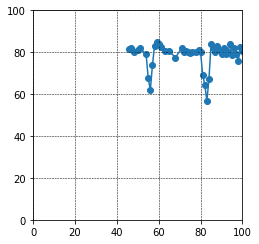

In [ ]:
digitization(path)

In [ ]:
inference(path)

1/1 [==============================] - 0s 147ms/step


{'HR': '92', 'DBP': '82', 'SPO2': '98', 'RR': '26'}